## **Tema AVMD**

In [1]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

plt.style.use('seaborn-v0_8-whitegrid')
from matplotlib.pyplot import figure

matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None

### Incarcarea unui set de date dintr-un fisier csv intr-o colectie din MongoDB

In [3]:
dfw = pd.read_csv('C:/Users/therealisc/Documents/Weather.csv')
dfc = pd.read_csv('C:/Users/therealisc/Documents/WorldCities.csv')

data_dict_weather = dfw.to_dict('records')
data_dict_cities = dfc.to_dict('records')

with open('C:/Users/therealisc/Documents/mongo.txt') as f:
    uri = f.readline().strip('\n')

with MongoClient(uri) as client:
    db = client.avmd  # avmd is the database name
    weather_events = db.weather_events  # weather_events is the collection name
    cities = db.cities # cities is the collection name

    if weather_events.count_documents({}) > 0:
        print('weather_events collection has documents')
    else:
        result = weather_events.insert_many(data_dict_weather)

    if cities.count_documents({}) > 0:
        print('cities collection has documents')
    else:
        result = cities.insert_many(data_dict_cities)

weather_events collection has documents
cities collection has documents


### Returnarea datelor din MongoDB

In [4]:
with MongoClient(uri) as client:
    db = client.avmd
    weather_events = db.weather_events
    cities = db.cities
    projection = {"_id": 0}
    cursor = weather_events.find({}, projection=projection)
    weather_events_df = pd.DataFrame.from_dict(list(cursor))
    cursor = cities.find({}, projection=projection)
    cities_df = pd.DataFrame.from_dict(list(cursor))
    cursor.close()

weather_events_df

,rownames,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,...,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,29,Auckland,2016-01-29,2016,1,29,77,72,68,68,...,29.91,29.80,6,6,5,15,7,NaN,0,Rain
1,3,Auckland,2016-01-03,2016,1,3,77,72,66,70,...,29.73,29.68,6,6,1,18,12,NaN,0,Rain
2,41,Auckland,2016-02-10,2016,2,10,78,72,66,68,...,29.84,29.77,6,6,6,14,6,NaN,0,Rain
3,11,Auckland,2016-01-11,2016,1,11,75,67,59,61,...,30.03,29.95,6,6,6,17,10,26.0,0,NaN
4,8,Auckland,2016-01-08,2016,1,8,77,70,64,72,...,29.79,29.62,6,6,2,21,14,28.0,0,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,21,Auckland,2016-01-21,2016,1,21,78,71,64,64,...,30.10,30.09,6,6,6,15,6,NaN,0,NaN
3657,41,Auckland,2016-02-10,2016,2,10,78,72,66,68,...,29.84,29.77,6,6,6,14,6,NaN,0,Rain
3658,61,Auckland,2016-03-01,2016,3,1,71,68,64,68,...,29.98,29.92,6,6,4,15,7,NaN,0,Rain
3659,121,Auckland,2016-04-30,2016,4,30,68,62,55,55,...,30.31,30.27,6,6,6,15,9,NaN,0,NaN


### Afisarea coloanelor numerice

In [5]:
df_numeric = weather_events_df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print("Coloane numerice:", numeric_cols)

Coloane numerice: ['rownames' 'year' 'month' 'day' 'high_temp' 'avg_temp' 'low_temp'
 'high_dewpt' 'avg_dewpt' 'low_dewpt' 'high_humidity' 'avg_humidity'
 'low_humidity' 'high_hg' 'avg_hg' 'low_hg' 'high_vis' 'avg_vis' 'low_vis'
 'high_wind' 'avg_wind' 'low_wind']


### Afisare coloane non-numerice

In [6]:
df_non_numeric = weather_events_df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("Coloane non-numerice:", non_numeric_cols)

Coloane non-numerice: ['city' 'date' 'precip' 'events']


### Afisare coloane cu valori lipsa utilizand un heatmap

low_wind    1332
events      2220
dtype: int64


<Axes: >

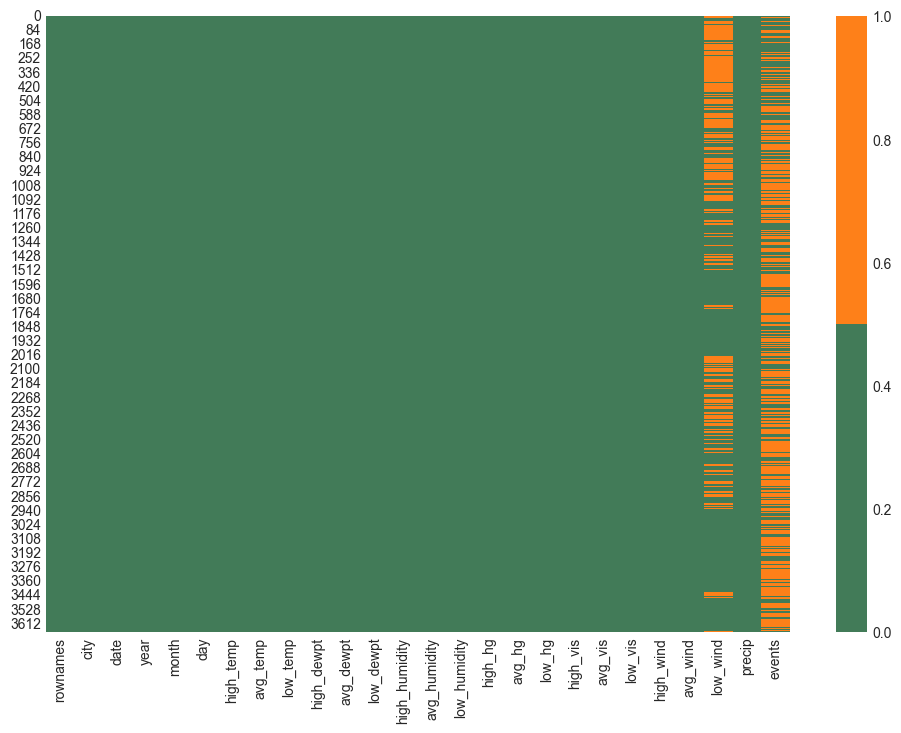

In [7]:
empty_cols = weather_events_df.isna().sum()
empty_cols = empty_cols[empty_cols != 0]
print(empty_cols) # afisare doar coloane cu valori necompletate
cols = weather_events_df.columns
colours = ['#427b58', '#fe8019']  # culoarea portocalie pentru valorile inexistente.
sns.heatmap(weather_events_df[cols].isnull(), cmap=sns.color_palette(colours))

### Inlocuire valori lipsa cu media valorilor pentru coloana numerica _low_wind_

In [8]:
for col in numeric_cols:
    missing = weather_events_df[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:
        print('missing values for: {}'.format(col))
        weather_events_df['{}_ismissing'.format(col)] = missing
        med = weather_events_df[col].median()
        weather_events_df[col] = weather_events_df[col].fillna(med)

missing values for: low_wind


### Inlocuirea valorilor lipsa cu valori implicite pentru coloana non-numerica _events_

In [9]:
weather_events_df['events'] = weather_events_df['events'].fillna('None recorded')
weather_events_df

,rownames,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,...,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events,low_wind_ismissing
0,29,Auckland,2016-01-29,2016,1,29,77,72,68,68,...,29.80,6,6,5,15,7,22.0,0,Rain,True
1,3,Auckland,2016-01-03,2016,1,3,77,72,66,70,...,29.68,6,6,1,18,12,22.0,0,Rain,True
2,41,Auckland,2016-02-10,2016,2,10,78,72,66,68,...,29.77,6,6,6,14,6,22.0,0,Rain,True
3,11,Auckland,2016-01-11,2016,1,11,75,67,59,61,...,29.95,6,6,6,17,10,26.0,0,None recorded,False
4,8,Auckland,2016-01-08,2016,1,8,77,70,64,72,...,29.62,6,6,2,21,14,28.0,0,Rain,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,21,Auckland,2016-01-21,2016,1,21,78,71,64,64,...,30.09,6,6,6,15,6,22.0,0,None recorded,True
3657,41,Auckland,2016-02-10,2016,2,10,78,72,66,68,...,29.77,6,6,6,14,6,22.0,0,Rain,True
3658,61,Auckland,2016-03-01,2016,3,1,71,68,64,68,...,29.92,6,6,4,15,7,22.0,0,Rain,True
3659,121,Auckland,2016-04-30,2016,4,30,68,62,55,55,...,30.27,6,6,6,15,9,22.0,0,None recorded,True


### Afisarea randurilor duplicate

In [10]:
key = ['rownames']
weather_events_df.groupby(key)['rownames'].count().sort_values(ascending=False).head(30)


rownames
21      3
121     2
61      2
141     2
41      2
1       1
2442    1
2433    1
2434    1
2435    1
2436    1
2437    1
2438    1
2439    1
2440    1
2441    1
2443    1
2431    1
2444    1
2445    1
2446    1
2447    1
2448    1
2449    1
2450    1
2451    1
2452    1
2453    1
2454    1
2455    1
Name: rownames, dtype: int64

### Eliminarea duplicatelor

In [11]:
weather_events_df.drop_duplicates(subset = key, inplace=True)

### Jonctiune dataframes

<Axes: >

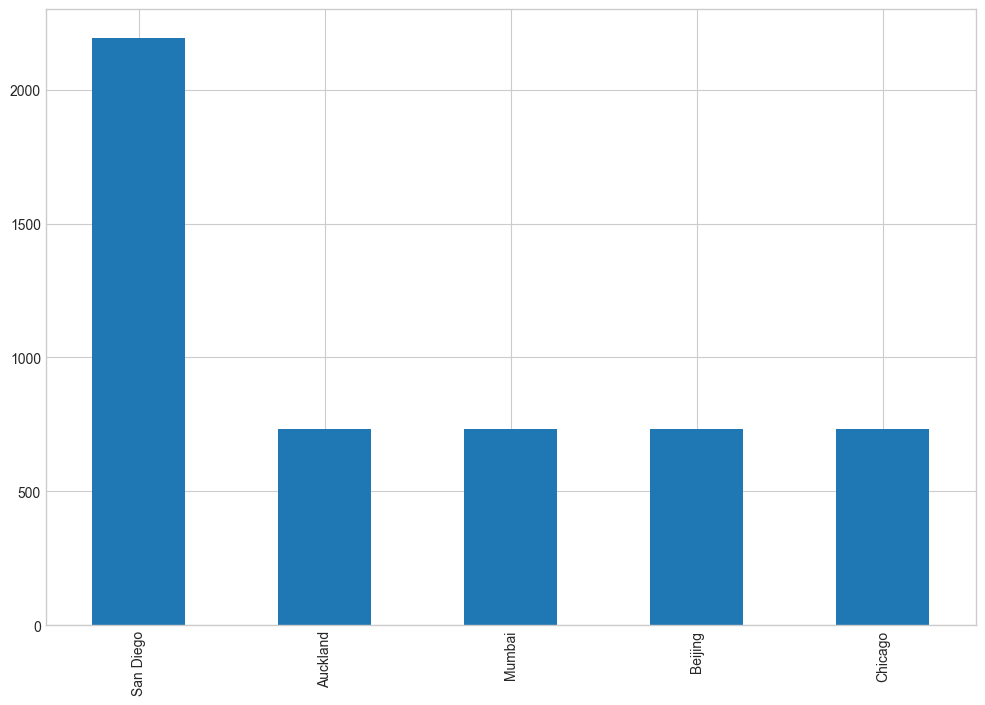

In [12]:
df = pd.merge(weather_events_df, cities_df, left_on=weather_events_df['city'], right_on=cities_df['city'])
df['city_ascii'].value_counts().plot.bar() # city_ascii comes from cities_df so the dataframes were merge successfully

### Returnare date din MongoDB in vederea transformarii variabilelor categoriale, scalarii si normalizarii

In [13]:
with MongoClient(uri) as client:
    db = client.avmd
    weather_events = db.weather_events
    projection = {
        "_id": 0,
        "date": 1,
        "high_temp": 1,
        "avg_temp": 1,
        "low_temp": 1,
        "high_dewpt": 1,
        "low_hg": 1,
        "high_vis": 1,
        "avg_vis": 1,
        "low_vis": 1,
        "high_wind": 1,
        "avg_wind": 1,
        "low_wind": 1,
        "precip": 1,
        "events": 1
    }
    cursor = weather_events.find({}, projection=projection)
    weather_events_df = pd.DataFrame.from_dict(list(cursor))
    cursor.close()

### Transformare variabile categoriale in variabile numerice si transformare variabile data in variabile numerice

In [14]:
labelEncoder = LabelEncoder()
weather_events_df['events'] = labelEncoder.fit_transform(weather_events_df['events'].astype(str))
weather_events_df['date'] = pd.to_datetime(weather_events_df['date']).apply(lambda x: x.value)

weather_events_df['precip'] = weather_events_df['precip'].replace('T', 'NaN')

weather_events_df

,date,high_temp,avg_temp,low_temp,high_dewpt,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,1454025600000000000,77,72,68,68,29.80,6,6,5,15,7,NaN,0,7
1,1451779200000000000,77,72,66,70,29.68,6,6,1,18,12,NaN,0,7
2,1455062400000000000,78,72,66,68,29.77,6,6,6,14,6,NaN,0,7
3,1452470400000000000,75,67,59,61,29.95,6,6,6,17,10,26.0,0,14
4,1452211200000000000,77,70,64,72,29.62,6,6,2,21,14,28.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,1453334400000000000,78,71,64,64,30.09,6,6,6,15,6,NaN,0,14
3657,1455062400000000000,78,72,66,68,29.77,6,6,6,14,6,NaN,0,7
3658,1456790400000000000,71,68,64,68,29.92,6,6,4,15,7,NaN,0,7
3659,1461974400000000000,68,62,55,55,30.27,6,6,6,15,9,NaN,0,14


### Inlcuirea valorilor lipsa

In [15]:
weather_events_df.fillna(weather_events_df.mean(numeric_only=True), inplace=True)
weather_events_df

,date,high_temp,avg_temp,low_temp,high_dewpt,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,1454025600000000000,77,72,68,68,29.80,6,6,5,15,7,24.384714,0,7
1,1451779200000000000,77,72,66,70,29.68,6,6,1,18,12,24.384714,0,7
2,1455062400000000000,78,72,66,68,29.77,6,6,6,14,6,24.384714,0,7
3,1452470400000000000,75,67,59,61,29.95,6,6,6,17,10,26.000000,0,14
4,1452211200000000000,77,70,64,72,29.62,6,6,2,21,14,28.000000,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,1453334400000000000,78,71,64,64,30.09,6,6,6,15,6,24.384714,0,14
3657,1455062400000000000,78,72,66,68,29.77,6,6,6,14,6,24.384714,0,7
3658,1456790400000000000,71,68,64,68,29.92,6,6,4,15,7,24.384714,0,7
3659,1461974400000000000,68,62,55,55,30.27,6,6,6,15,9,24.384714,0,14


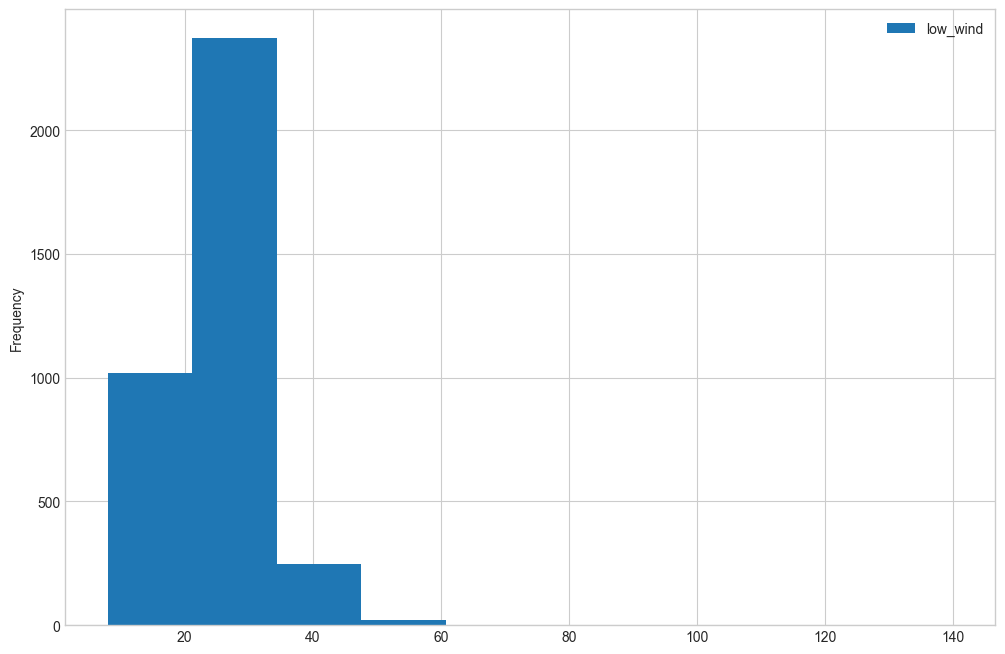

In [16]:
weather_events_df.plot(y="low_wind", kind='hist')
plt.show()

### Scalare valori cu RobustScaler

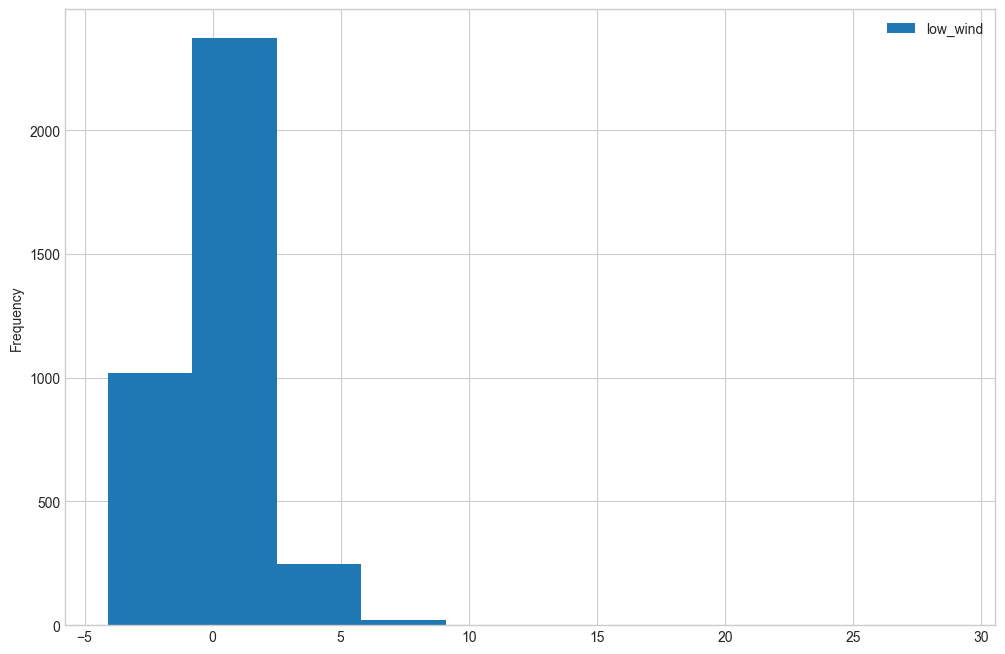

In [17]:
scaler = RobustScaler(quantile_range= (25, 75))
scaler.fit(weather_events_df)
scaled_weather_events_df = scaler.transform(weather_events_df)

cols=weather_events_df.columns.tolist()
scaled_weather_events_df = pd.DataFrame(data=scaled_weather_events_df, columns=cols)
scaled_weather_events_df.plot(y="low_wind", kind='hist')
plt.show()

### Normalizare valori cu QuantileTransformer

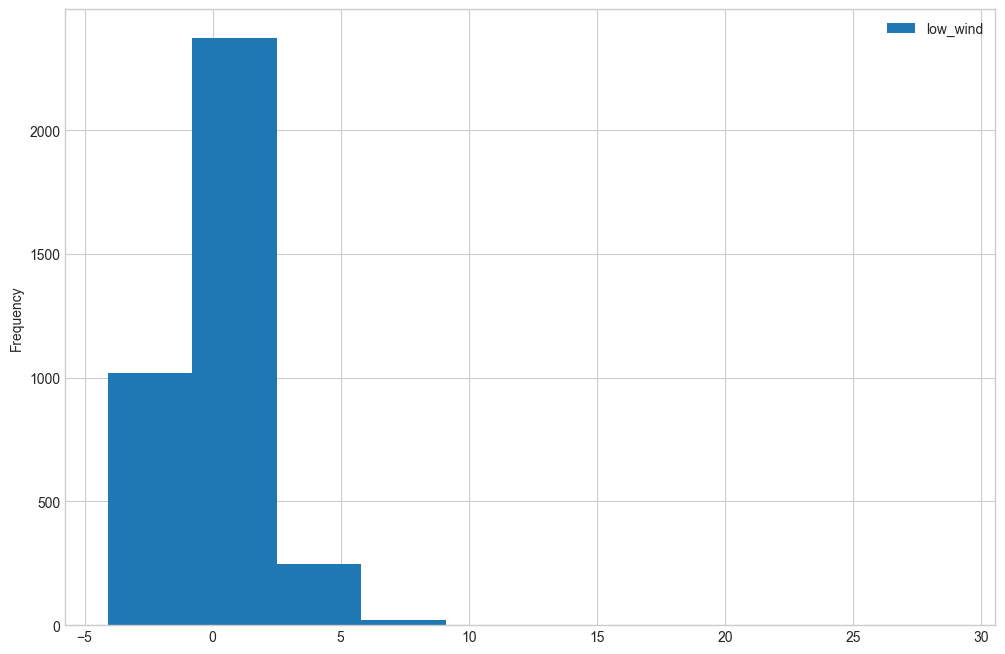

In [18]:
normalizer = QuantileTransformer(n_quantiles=10, random_state=0)
normalizer.fit(weather_events_df)
normalized_weather_events_df = scaler.transform(weather_events_df)

normalized_weather_events_df = pd.DataFrame(data=normalized_weather_events_df, columns=cols)
normalized_weather_events_df.plot(y="low_wind", kind='hist')
plt.show()

### Statistici descriptive

In [19]:
with MongoClient(uri) as client:
    db = client.avmd
    collection = db["weather_events"]
    projection = {"_id":0}
    sort = [("row_names", 1)]
    cursor = collection.find({},projection=projection, sort=sort)
    dfm  = pd.DataFrame.from_dict(list(cursor))
    cursor.close()

dfm.describe()


,rownames,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,...,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind
count,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,...,3661.000000,3661.000000,3661.000000,3661.00000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,2329.000000
mean,1825.114996,2016.498498,6.513521,15.741054,71.327779,63.262770,54.962852,55.978421,51.004917,45.430757,...,46.361650,30.040645,29.963748,29.88982,8.222070,6.710735,4.599017,16.292543,7.464081,24.384714
std,1056.790631,0.500066,3.451244,8.806085,17.179005,16.664737,17.095065,17.640717,19.094372,20.745437,...,20.924292,0.223304,0.219518,0.22231,4.426833,3.563272,3.645768,6.741392,3.862618,8.475842
min,1.000000,2016.000000,1.000000,1.000000,5.000000,1.000000,-13.000000,-17.000000,-24.000000,-29.000000,...,4.000000,29.300000,29.200000,29.06000,1.000000,0.000000,0.000000,4.000000,1.000000,8.000000
25%,910.000000,2016.000000,4.000000,8.000000,62.000000,56.000000,47.000000,50.000000,43.000000,36.000000,...,30.000000,29.890000,29.820000,29.74000,6.000000,4.000000,1.000000,13.000000,5.000000,18.000000
50%,1825.000000,2016.000000,7.000000,16.000000,73.000000,66.000000,59.000000,59.000000,55.000000,50.000000,...,51.000000,30.010000,29.950000,29.89000,10.000000,6.000000,4.000000,15.000000,6.000000,22.000000
75%,2740.000000,2017.000000,10.000000,23.000000,86.000000,76.000000,66.000000,67.000000,63.000000,59.000000,...,63.000000,30.160000,30.090000,30.03000,10.000000,10.000000,8.000000,20.000000,9.000000,29.000000
max,3655.000000,2017.000000,12.000000,31.000000,102.000000,90.000000,84.000000,86.000000,80.000000,79.000000,...,94.000000,30.910000,30.840000,30.80000,19.000000,19.000000,19.000000,128.000000,28.000000,140.000000


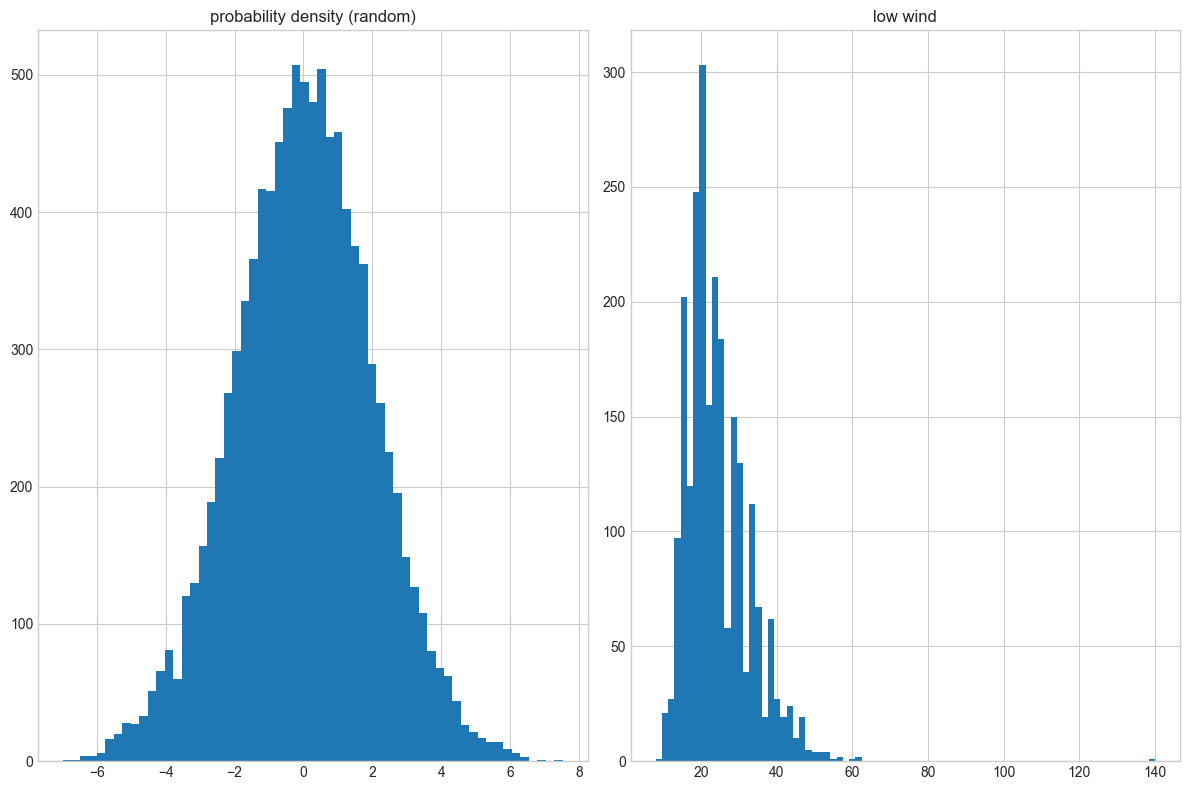

In [20]:
from scipy.stats import kurtosis, skew
x_random = np.random.normal(0, 2, 10000)
y = dfm['low_wind']

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(x_random, bins='auto')
ax1.set_title('probability density (random)')
ax2.hist(y, bins='auto')
ax2.set_title('low wind')
plt.tight_layout()
plt.show()

In [21]:
print(dfm.skew(numeric_only=True))

rownames         0.000597
year             0.006012
month           -0.005892
day              0.005140
high_temp       -0.760550
avg_temp        -0.913869
low_temp        -0.927337
high_dewpt      -1.001461
avg_dewpt       -0.956926
low_dewpt       -0.866053
high_humidity   -1.298584
avg_humidity    -0.751913
low_humidity    -0.382747
high_hg          0.503914
avg_hg           0.366360
low_hg           0.189268
high_vis         0.751958
avg_vis          0.274353
low_vis          0.471310
high_wind        3.824229
avg_wind         1.282297
low_wind         1.933694
dtype: float64


medie :  24.3847144697295
varianta  :  71.80905789399843
skewness :  nan
kurtosis :  nan


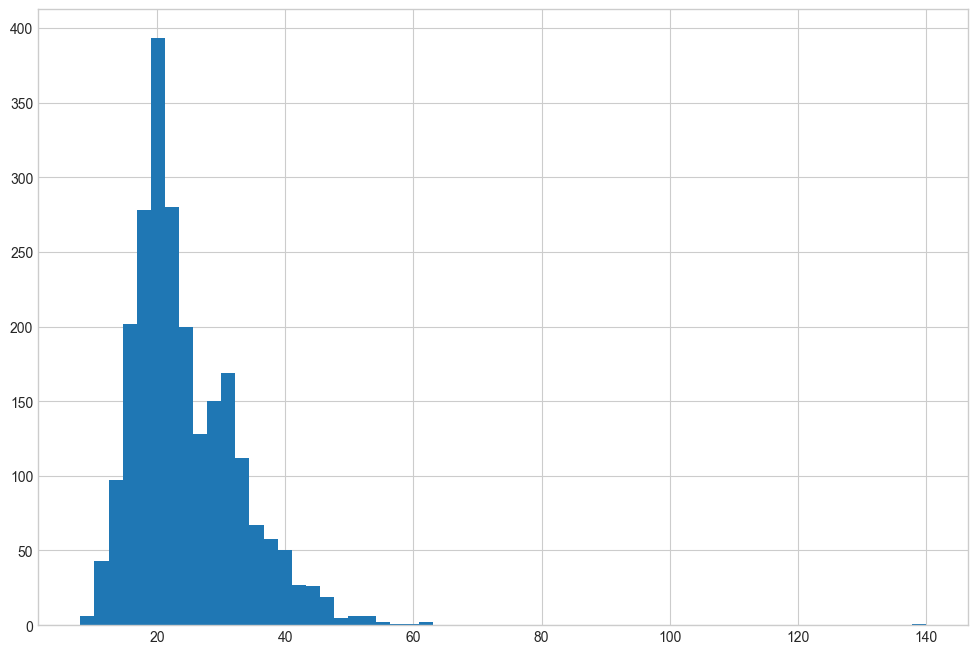

In [22]:
plt.hist(y, bins=60)
print("medie : ", np.mean(y))
print("varianta  : ", np.var(y))
print("skewness : ", skew(y))
print("kurtosis : ", kurtosis(y))
plt.show()

### Calculare coeficient de corelatie

In [23]:
dfm.corr(numeric_only=True)

,rownames,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,...,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind
rownames,1.000000,0.175392,0.102691,0.008438,-0.125697,-0.127570,-0.133593,-0.221953,-0.219312,-0.216568,...,-0.141317,0.132527,0.147020,0.146598,0.478030,0.541573,0.443522,-0.038503,-0.146903,-0.424268
year,0.175392,1.000000,0.003613,-0.002322,0.010362,0.004572,-0.001445,-0.004479,-0.007553,-0.006904,...,-0.024258,-0.018881,-0.022399,-0.026325,0.028847,0.020380,0.011809,-0.007772,-0.007065,0.015931
month,0.102691,0.003613,1.000000,0.008934,0.066175,0.081847,0.093128,0.114085,0.106475,0.104566,...,0.076533,-0.048411,-0.038645,-0.026922,-0.033004,-0.019666,0.013612,-0.060314,-0.040181,-0.061968
day,0.008438,-0.002322,0.008934,1.000000,0.005535,0.005964,0.006439,0.012095,0.005506,0.003412,...,0.009503,-0.013218,-0.015064,-0.018432,0.012634,0.005492,-0.024102,0.001129,0.012249,0.043709
high_temp,-0.125697,0.010362,0.066175,0.005535,1.000000,0.973453,0.896803,0.863023,0.819173,0.755931,...,-0.081274,-0.640212,-0.561499,-0.473243,-0.347917,-0.350377,-0.200930,-0.159234,-0.293964,-0.151751
avg_temp,-0.127570,0.004572,0.081847,0.005964,0.973453,1.000000,0.973776,0.929807,0.904708,0.858161,...,0.099796,-0.690209,-0.604477,-0.507804,-0.396268,-0.359491,-0.188946,-0.133326,-0.223277,-0.162538
low_temp,-0.133593,-0.001445,0.093128,0.006439,0.896803,0.973776,1.000000,0.948977,0.943862,0.916363,...,0.274670,-0.704526,-0.616560,-0.516405,-0.428590,-0.357711,-0.174363,-0.103032,-0.142347,-0.162658
high_dewpt,-0.221953,-0.004479,0.114085,0.012095,0.863023,0.929807,0.948977,1.000000,0.982212,0.941936,...,0.367065,-0.714359,-0.646429,-0.560890,-0.525156,-0.487792,-0.308815,-0.098066,-0.152020,-0.101771
avg_dewpt,-0.219312,-0.007553,0.106475,0.005506,0.819173,0.904708,0.943862,0.982212,1.000000,0.982834,...,0.462627,-0.707440,-0.631846,-0.539744,-0.552964,-0.487409,-0.288787,-0.113081,-0.142540,-0.135626
low_dewpt,-0.216568,-0.006904,0.104566,0.003412,0.755931,0.858161,0.916363,0.941936,0.982834,1.000000,...,0.542570,-0.676643,-0.594303,-0.500182,-0.558982,-0.460371,-0.249806,-0.123522,-0.120102,-0.159062


### Calculare coeficient de corelatie cu metoda spearman

In [24]:
dfm.corr(method = 'spearman',numeric_only=True)

,rownames,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,...,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind
rownames,1.000000,0.175468,0.102807,0.008447,-0.104951,-0.111420,-0.110484,-0.248414,-0.235338,-0.214627,...,-0.160726,0.156533,0.180056,0.183778,0.622904,0.590857,0.410364,-0.034173,-0.110148,-0.518234
year,0.175468,1.000000,0.003609,-0.002323,0.005581,-0.000002,-0.010560,-0.005509,-0.008294,-0.007991,...,-0.025356,-0.026075,-0.025571,-0.025694,0.026902,0.015292,0.013447,0.005847,-0.002683,0.007529
month,0.102807,0.003609,1.000000,0.008902,0.052000,0.069587,0.081422,0.089608,0.081455,0.083379,...,0.072072,-0.052017,-0.037812,-0.026084,-0.030525,-0.013429,0.009599,-0.072635,-0.051265,-0.072806
day,0.008447,-0.002323,0.008902,1.000000,0.008406,0.006495,0.005746,0.012020,0.003241,-0.001521,...,0.016147,-0.025310,-0.023836,-0.024554,0.010843,0.006128,-0.013986,0.012420,0.013419,0.043708
high_temp,-0.104951,0.005581,0.052000,0.008406,1.000000,0.965626,0.860351,0.838616,0.781673,0.695658,...,-0.173725,-0.609234,-0.540716,-0.472311,-0.369965,-0.355878,-0.248821,-0.203381,-0.268478,-0.098267
avg_temp,-0.111420,-0.000002,0.069587,0.006495,0.965626,1.000000,0.959878,0.917403,0.885906,0.822486,...,0.005833,-0.665483,-0.587242,-0.509790,-0.414253,-0.381063,-0.258744,-0.170108,-0.190146,-0.112230
low_temp,-0.110484,-0.010560,0.081422,0.005746,0.860351,0.959878,1.000000,0.937934,0.938835,0.906510,...,0.204674,-0.673511,-0.589400,-0.506294,-0.424390,-0.368514,-0.234562,-0.125345,-0.094380,-0.121282
high_dewpt,-0.248414,-0.005509,0.089608,0.012020,0.838616,0.917403,0.937934,1.000000,0.975158,0.919107,...,0.262698,-0.668905,-0.605496,-0.535241,-0.519842,-0.493369,-0.372565,-0.123260,-0.113919,-0.047362
avg_dewpt,-0.235338,-0.008294,0.081455,0.003241,0.781673,0.885906,0.938835,0.975158,1.000000,0.974083,...,0.365509,-0.651305,-0.579199,-0.502728,-0.515314,-0.473823,-0.339163,-0.126295,-0.093113,-0.081199
low_dewpt,-0.214627,-0.007991,0.083379,-0.001521,0.695658,0.822486,0.906510,0.919107,0.974083,1.000000,...,0.466940,-0.612008,-0.533724,-0.455567,-0.486680,-0.419084,-0.272682,-0.117158,-0.054973,-0.110853


### Calculare coeficient de corelatie cu metoda kendall

In [25]:
dfm.corr(method = 'kendall', numeric_only=True)

,rownames,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,...,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind
rownames,1.000000,0.143289,0.097945,0.008280,-0.067225,-0.062388,-0.053614,-0.132497,-0.125312,-0.118176,...,-0.094060,0.085952,0.104612,0.111767,0.375990,0.385104,0.271169,-0.036070,-0.078976,-0.352391
year,0.143289,1.000000,0.003067,-0.001928,0.004605,-0.000001,-0.008718,-0.004557,-0.006838,-0.006594,...,-0.020869,-0.021505,-0.021022,-0.021197,0.024089,0.013437,0.011740,0.004922,-0.002288,0.006274
month,0.097945,0.003067,1.000000,0.006280,0.035678,0.050253,0.058639,0.063119,0.056170,0.056520,...,0.049578,-0.038059,-0.026579,-0.017249,-0.023381,-0.009847,0.007233,-0.052027,-0.037797,-0.052911
day,0.008280,-0.001928,0.006280,1.000000,0.005784,0.004409,0.003995,0.008313,0.002189,-0.001141,...,0.011053,-0.017258,-0.016288,-0.016957,0.008031,0.004419,-0.010341,0.008681,0.009428,0.030306
high_temp,-0.067225,0.004605,0.035678,0.005784,1.000000,0.858801,0.691792,0.669761,0.612067,0.534907,...,-0.129417,-0.447493,-0.395977,-0.347203,-0.263876,-0.240041,-0.166514,-0.145597,-0.192274,-0.052642
avg_temp,-0.062388,-0.000001,0.050253,0.004409,0.858801,1.000000,0.850830,0.775558,0.734174,0.661669,...,-0.001049,-0.504545,-0.442948,-0.385881,-0.295559,-0.255629,-0.177428,-0.120823,-0.133594,-0.059001
low_temp,-0.053614,-0.008718,0.058639,0.003995,0.691792,0.850830,1.000000,0.808757,0.811850,0.763594,...,0.138335,-0.513944,-0.445407,-0.382627,-0.314723,-0.258554,-0.166306,-0.086155,-0.061389,-0.066619
high_dewpt,-0.132497,-0.004557,0.063119,0.008313,0.669761,0.775558,0.808757,1.000000,0.897522,0.789436,...,0.182924,-0.508277,-0.457814,-0.405210,-0.400466,-0.366444,-0.277917,-0.085018,-0.077534,-0.018983
avg_dewpt,-0.125312,-0.006838,0.056170,0.002189,0.612067,0.734174,0.811850,0.897522,1.000000,0.891899,...,0.257355,-0.492455,-0.434021,-0.376557,-0.398246,-0.353491,-0.251693,-0.085661,-0.060796,-0.042070
low_dewpt,-0.118176,-0.006594,0.056520,-0.001141,0.534907,0.661669,0.763594,0.789436,0.891899,1.000000,...,0.332837,-0.457250,-0.393775,-0.335246,-0.376014,-0.313595,-0.201554,-0.078528,-0.032932,-0.064606


### Reprezentare grafica _low_wind_ si _high_humidity_

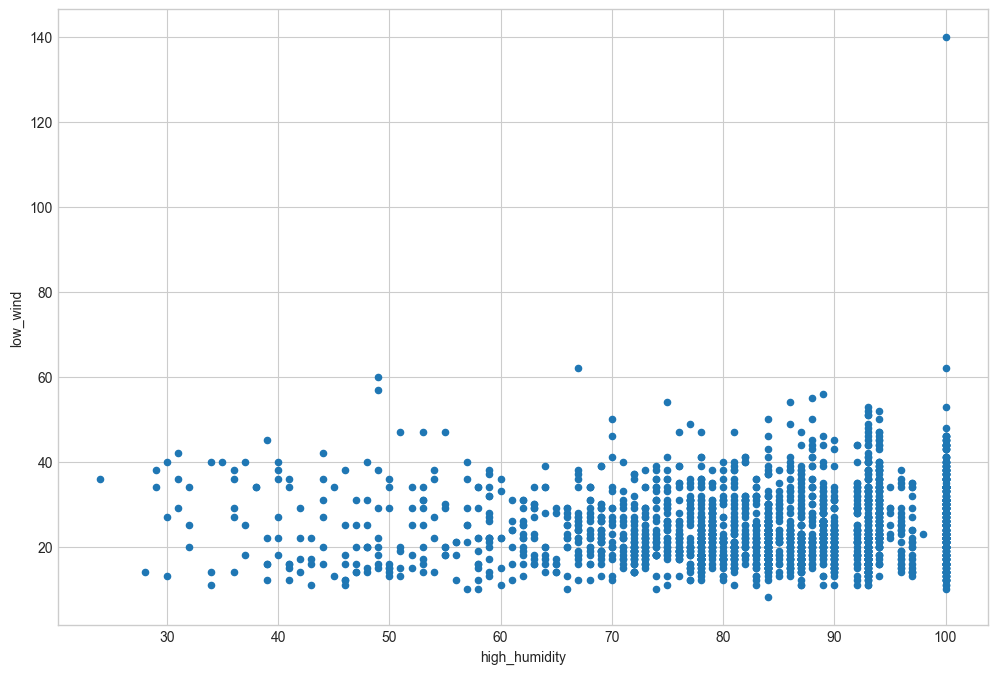

In [26]:
dfm.plot(x="high_humidity", y="low_wind", kind="scatter")
plt.show()

### Reprezentare grafica _avg_temp_ si _avg_humidity_

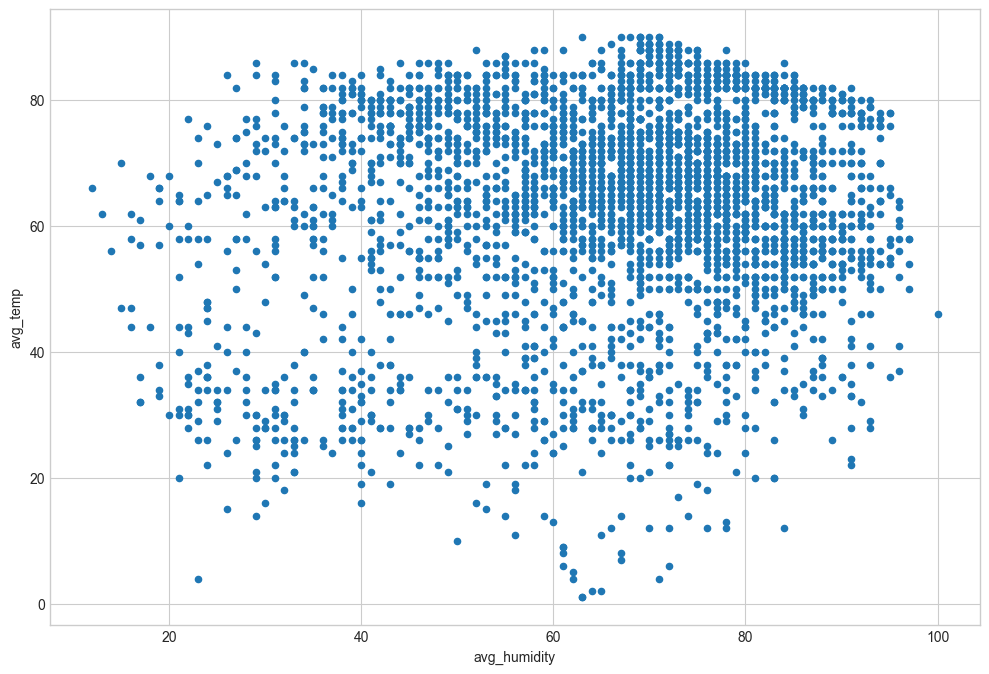

In [27]:
dfm.plot(x="avg_humidity", y="avg_temp", kind="scatter")
plt.show()

### Grafic de tip barchart pentru datele inregistrate in anul 2016, in orasul Chicago in ultimele 10 zile ale lunii curente

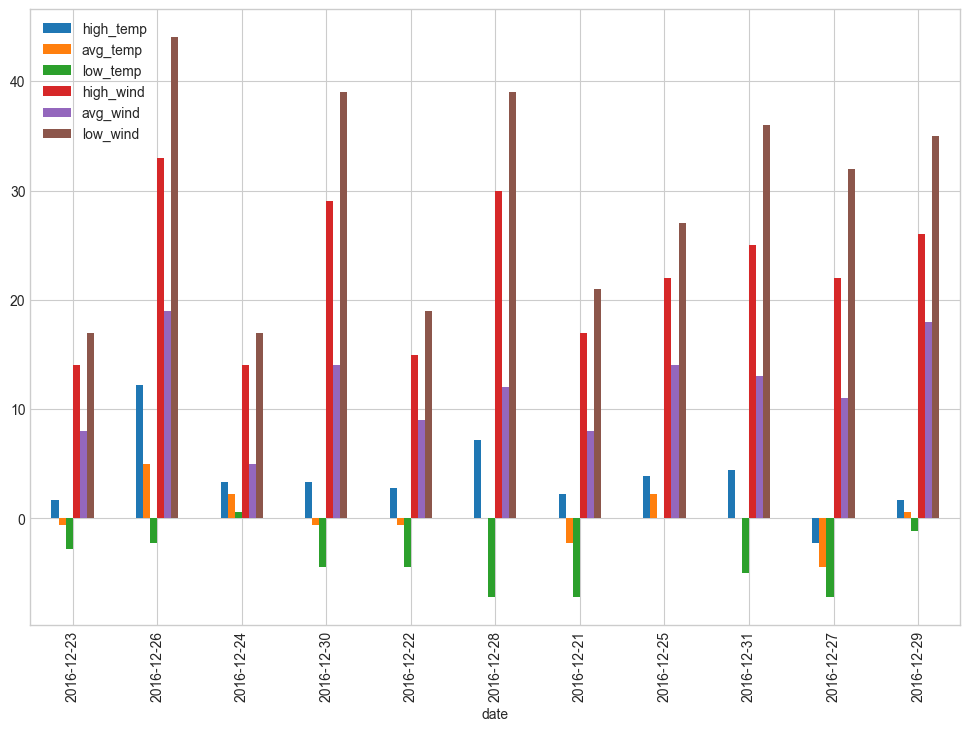

In [28]:
from datetime import datetime

with MongoClient(uri) as client:
    db = client.avmd
    weather_events = db.weather_events
    projection = {
        "_id": 0,
        "date": 1,
        "city": 1,
        "high_temp": 1,
        "avg_temp": 1,
        "low_temp": 1,
        "high_wind": 1,
        "avg_wind": 1,
        "low_wind": 1,
        "precip": 1,
        "events": 1
    }
    cursor = weather_events.find({"year": 2016, "month": datetime.now().month, "city": "Chicago", "day": { '$gt': 20 }}, projection=projection)
    weather_events_df = pd.DataFrame.from_dict(list(cursor))
    cursor.close()

# Fahrenheit to Celsius
weather_events_df['high_temp'] = (weather_events_df['high_temp'] - 32) * 5/9
weather_events_df['avg_temp'] = (weather_events_df['avg_temp'] - 32) * 5/9
weather_events_df['low_temp'] = (weather_events_df['low_temp'] - 32) * 5/9

weather_events_df.plot.bar(x='date')
plt.show()